# Assignment 3: Dino Fun World Analysis

The administrators of Dino Fun World, a local amusement park, have asked you, one of their data analysts, to perform three data analysis tasks for their park. These tasks will involve understanding, analysing, and graphing attendance data for one day of the park's operations that the park has provided for you to use. They have provided the data in the form of a database, described below.

### Provided Database

The database provided by the park administration is formatted to be readable by any SQL database library. The course staff recommends the sqlite3 library. The database contains three tables, named 'checkins', 'attractions', and 'sequences'. The information contained in each of these tables is listed below:

`checkins`:
    - Description: check-in data for all visitors for the day in the park. The data includes two types of check-ins, inferred and actual checkins.
    - Fields: visitorID, timestamp, attraction, duration, type
`attraction`:
    - The attractions in the park by their corresponding AttractionID, Name, Region, Category, and type. Regions are from the VAST Challenge map such as Coaster Alley, Tundra Land, etc. Categories include Thrill rides, Kiddie Rides, etc. Type is broken into Outdoor Coaster, Other Ride, Carussel, etc.
    - Fields: AttractionID, Name, Region, Category, type
`sequences`:
    - The check-in sequences of visitors. These sequences list the position of each visitor to the park every five minutes. If the visitor has not entered the part yet, the sequence has a value of 0 for that time interval. If the visitor is in the park, the sequence lists the attraction they have most recently checked in to until they check in to a new one or leave the park.
    - Fields: visitorID, sequence
    
The database is named 'dinofunworld.db' and is located in the 'readonly' directory of the Jupyter Notebook environment. It can be accessed at 'readonly/dinofunworld.db'.
    

### Questions to Answer

1: The park's administrators would like you to help them understand the different paths visitors take through the park and different rides they visit. In this mission, they have selected 5 visitors at random whose checkin sequences they would like you to analyze. For now, they would like you to construct a distance matrix for these 5 visitors. The five visitors have the ids: 165316, 1835254, 296394, 404385, and 448990.

2: The park's administrators would like to understand the attendance dynamics at each ride (note that not all attractions are rides). They would like to see the minimum (non-zero) attendance at each ride, the average attendance over the whole day, and the maximum attendance for each ride on a Parallel Coordinate Plot.

3: In addition to a PCP, the administrators would like to see a Scatterplot Matrix depicting the min, average, and max attendance for each ride as above. 

#### Administrative Notes

This assignment will be graded by Coursera's grading system. In order for your answers to be correctly registered in the system, you must place the code for your answers in the cell indicated for each question. In addition, you should submit the assignment with the output of the code in the cell's display area. The display area should contain only your answer to the question with no extraneous information, or else the answer may not be picked up correctly. Each cell that is going to be graded has a set of comment lines at the beginning of the cell. These lines are extremely important and must not be modified or removed.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
con = sqlite3.connect('readonly/dinofunworld.db')
cur = con.cursor()

In [2]:
# Graded Cell, PartID: IiXwN
# Create a distance matrix suitable for use in hierarchical clustering of the
# checkin sequences of the 5 specified visitors. Your distance function should
# count the number of dissimilarities in the sequences without considering any
# other factors. The distance matrix should be reported as a dictionary of
# dictionaries (eg. {1: {2:0, 3:0, 4:0}, 2: {1:0, 3:0, ...}, ...}).
cur.execute("SELECT visitorID, sequence FROM sequences where visitorID IN (165316, 1835254, 296394, 404385, 448990);")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'].apply(lambda s: s.split("-"))
outer_dict = {}
for i in range(5):
    for j in range(i+1, 5):
        dist = sum(int(v1) != int(v2) for v1, v2 in zip(sequence_stats['sequence_list'][i], sequence_stats['sequence_list'][j]))
        id_i = sequence_stats['visitor'][i]
        id_j = sequence_stats['visitor'][j]
        innerDict_i = outer_dict.get(id_i, {})
        innerDict_i[id_j] = dist
        outer_dict[id_i] = innerDict_i
        innerDict_j = outer_dict.get(id_j, {})
        innerDict_j[id_i] = dist
        outer_dict[id_j] = innerDict_j
print(outer_dict)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


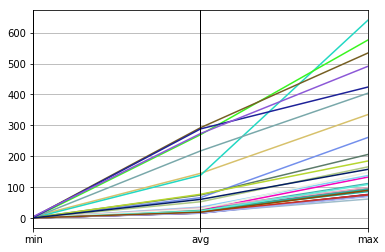

                         ride  min         avg  max
0                   Atmosfear    5  144.986056  335
1          Auvilotops Express    1  138.728745  640
2                  Beelzebufo    1   18.239726   93
3              Blue Iguanodon    1   17.110360   73
4        Cyndisaurus Asteroid    1   16.873303   72
5         Dykesadactyl Thrill    1   18.413646   62
6        Eberlesaurus Roundup    1   20.740586   76
7        Enchanted Toadstools    1   16.357616   77
8                    Firefall    1  270.036145  576
9     Flight of the Swingodon    3  292.528000  534
10       Flying TyrAndrienkos    1   24.585313   98
11         Galactosaurus Rage    1   66.577551  261
12      Ichthyoroberts Rapids    1  217.588933  404
13            Jeredactyl Jump    1   26.783262  112
14              Jurassic Road    1   24.577406   86
15  Kauf's Lost Canyon Escape    1   26.951983  133
16       Keimosaurus Big Spin    2   74.935354  206
17          Kristanodon Kaper    1   35.885010  138
18          

In [3]:
# Graded Cell, PartID: 8S2jm
# Create and display a Parallel Coordinate Plot displaying the minimum, average, 
# and maximum attendance for each ride in the park (note that not all attractions
# are rides).
cur.execute("SELECT AttractionID, Name FROM attraction where LOWER(Category) LIKE '%ride%';")
attraction_name_category_list = cur.fetchall()
attractions = pd.DataFrame.from_records(attraction_name_category_list, columns=['attractionID', 'attractionName'])
cur.execute("SELECT visitorID, sequence FROM sequences;")
sequences = cur.fetchall()
sequence_stats = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequence_stats['sequence_list'] = sequence_stats['sequence'].apply(lambda s: s.split("-"))
outer_dict_q2 = {}
new_col_name = "sequence_list_attendance"
for i in range(len(attraction_name_category_list)):
    sequence_stats[new_col_name] = sequence_stats['sequence_list'] \
    .apply(lambda s: [1 if int(x) == int(attraction_name_category_list[i][0]) else 0 for x in s])
    attendance = np.sum(sequence_stats[new_col_name].values.tolist(), axis=0)
    attendance = attendance[np.nonzero(attendance)]
    min_attendance = np.min(attendance)
    avg_attendance = np.mean(attendance)
    max_attendance = np.max(attendance)
    inner_dict_q2 = {"min": min_attendance, "avg": avg_attendance, "max": max_attendance}
    outer_dict_q2[attraction_name_category_list[i][1]] = inner_dict_q2
output_frame_q2 = pd.DataFrame.from_dict(outer_dict_q2, orient='index')
output_frame_q2 = output_frame_q2.reset_index()
output_frame_q2.columns = ['ride' if x=='index' else x for x in output_frame_q2.columns]
pd.plotting.parallel_coordinates(output_frame_q2, 'ride')
plt.gca().legend_.remove()
plt.show()
print(output_frame_q2)

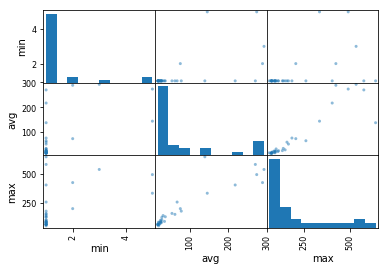

                         ride  min         avg  max
0                   Atmosfear    5  144.986056  335
1          Auvilotops Express    1  138.728745  640
2                  Beelzebufo    1   18.239726   93
3              Blue Iguanodon    1   17.110360   73
4        Cyndisaurus Asteroid    1   16.873303   72
5         Dykesadactyl Thrill    1   18.413646   62
6        Eberlesaurus Roundup    1   20.740586   76
7        Enchanted Toadstools    1   16.357616   77
8                    Firefall    1  270.036145  576
9     Flight of the Swingodon    3  292.528000  534
10       Flying TyrAndrienkos    1   24.585313   98
11         Galactosaurus Rage    1   66.577551  261
12      Ichthyoroberts Rapids    1  217.588933  404
13            Jeredactyl Jump    1   26.783262  112
14              Jurassic Road    1   24.577406   86
15  Kauf's Lost Canyon Escape    1   26.951983  133
16       Keimosaurus Big Spin    2   74.935354  206
17          Kristanodon Kaper    1   35.885010  138
18          

In [4]:
# Graded Cell, PartID: KHoww
# Create and display a Scatterplot Matrix displaying the minimum, average, and 
# maximum attendance for each ride in the park.
# Note: This is a different view into the same data as the previous part. While
# you work on these plots, consider the different things that each chart says
# about the data.
pd.plotting.scatter_matrix(output_frame_q2)
plt.show()
print(output_frame_q2)